# Discussion

For this assignment, I built a Flappy Bird simulation environment and implemented the epsilon-greedy strategy for a DQN neural network. The neural network was then trained to play Flappy Bird using the simulated environment, both with and without pipes (in the `pipes` and `flight` configuration, respectively). I'll briefly discuss these two components, then dive in to the results of training the neural network.

![Original Flappy Bird screenshot, from the HW3 assignment.](flappy-bird.jpg)

_The original Flappy Bird. This screenshot taken from the assignment._

## Flappy Bird Environment

![Screenshot of Simulated Flappy Bird Environment](env.jpg)

_My simulated flappy bird environment. A friend suggested that it ought to be called "Jumpy Rectangle."_

I built an environment that simulates the Flappy Bird game so that the neural network could be easily trained against it. The environment simulates a Flappy Bird game as a series of discrete time steps (_frames_). The environment lives in [`env.py`](env.py), and the specifications are as follows:


* A frame is 50x50px, where each pixel is either `0` (empty air), `1` (a wall or pipe), or `2` the bird. The origin of the frame's coordinate system is at the top left of the screen.
* Each frame has a 2px tall border along the entire top and bottom of the frame (the ceiling and floor, respectively).
* There are up to 2 pipes on the screen at each time, separated by a horizontal distance of 22px. Each pipe is 7px wide.
* Pipes move leftward at 1px/frame, entering from the right and exiting to the left. The first pipe starts 1px off the right edge of the screen, therefore becoming visible on the 2nd frame. Ergo, the second pipe is 22+7 = 29px off the right edge of the screen.
* Once a pipe has fully disappeared offscreen to the left, it is reintroduced from the right edge of the screen after 1 frame (ie. there is one frame where the pipe is not visible onscreen).
* Pipes are split in half vertically, with a 20px gap.
* In deterministic mode, both halves of each pipe are always the same length, 13px (excluding the border). Otherwise, the top half each pipe is assigned a random length between 3px and 22px (excluding the border). The bottom half of the pipe is sized to maintain the 20px gap.
* The bird is 5x5px. Its left edge is always in the 23rd column of pixels. (Which is as close to horizontally centered as it can be, given that it's an odd-width object in an even-width frame.)
* The bird's vertical position is adjusted by its velocity every frame. The bird's velocity starts at 0px/frame and accelerates by 2px/frame/frame downward by gravity each frame where the screen is not tapped. When the screen is tapped, the bird's velocity is reset to 5px/frame upwards (and no gravitational acceleration applies for that frame).
* At each time step, the environment returns an _observation_, which is composed of the most recent four frames. It also returns the neural network's reward (`-1` if the bird has crashed, `1` if it has just cleared a pipe, or `0` otherwise), and if the bird has crashed (which ends the episode).

The code is thoroughly documented, so I won't spend much time elaborating on it here. However, there are some details worth highlighting:

* Most environment logic is in the stateless, immutable dataclass `Frame`.
* I generally live by the maxim "design your model so that illegal states are unrepresentable" (that's a rough quote from someone), and that's true here: each `Frame` only stores the height and velocity of the bird and the height and position of each pipe. It uses this information to render the full 50x50px integer array on demand.
    * That array is recreated every time to reduce the likelihood of corrupting data.
* Because `Frame`s are immutable, a new one needs to be created for each time step. Each `Frame` is responsible for generating—but not keeping track of—its successor frame.
    * Because `Frame`s are stateless, `frame.next(...)` doesn't check if the game has already ended—that's a concern of `FlappyEnv`. If you wanted, you could keep calling `frame.next(...)` forever, although that behavior is undefined.
    * In order to properly generate the next `Frame`, `frame.next(...)` takes both the player's action and a function that generates a pipe height. Those arguments aren't the cleanest from a separation-of-concerns perspective, but seemed like the right trade off in terms of simplicity.
* NumPy arrays are used for representing rendered frames, because they offer vastly superior multi-dimensional indexing as compared to nested lists.
* `FlappyEnv` is a wrapper around `Frame` that keeps track of the last 4 `Frame`s to allow providing a full 4-frame observation. It also implements the required API.
* [`config.py`](config.py) stores all parameters for the game.

## Deep Q Network (DQN)

I also implemented the epsilon-greedy training strategy for the DQN. Epsilon-greedy forces the network to explore alternative options by picking a random choice a fixed proportion of the time (in our case, 5%). This allows the network to discover possibilities it otherwise would have never explored.

## Sticking Points

This assignment was relatively straightforward. The largest sticking point I encountered--and one which stumped both me and Jack for several hours--was a very subtle bug in my environment. It had no observable effect for the no-pipes configuration, but resulted in the network failing to ever progress past roughly 30 frames in with-pipes mode, no matter how much it was trained (up to and including one run for 50,000 episodes, nearly 7x the default length).

The function at fault was this one, from [`env.py`](env.py). Can you spot the error?

```python
class Frame:
    # ...

    def next(self, tap, get_pipe_height):
            """
            Generate the frame that succeeds this one.
            """
            new_pipes = []

            for left_x, top_height in self.pipes:
                # Wrap pipes around
                if left_x <= -PIPE_WIDTH:
                    # +1 so we have a frame with it offscreen
                    left_x = FRAME_WIDTH + 1
                    # re-randomize the height
                    top_height = get_pipe_height()

                new_pipes.append((left_x - 1, top_height))

            velocity = BIRD_TAP_VELOCITY \
                       if tap \
                       else (self.bird_velocity + BIRD_ACCELERATION)

            return Frame(
                pipes=new_pipes,
                bird_height=(self.bird_height + self.bird_velocity),
                bird_velocity=velocity
            )
```

The mistake is that the velocity which is computed based on the agent's action (`tap`) isn't used to calculate the `Frame` that's returned... it's used to calculate _the subsequent frame_. To correct the mistake, the end of `Frame.next(...)` needs to look like this:

```diff
    velocity = BIRD_TAP_VELOCITY \
             if tap \
             else (self.bird_velocity + BIRD_ACCELERATION)
  
  return Frame(
      pipes=new_pipes,
-     bird_height=(self.bird_height + self.bird_velocity),
+     bird_height=(self.bird_height + velocity),
      bird_velocity=velocity
  )
```

As best I can tell, it's impossible to successfully pass a pipe with this mistake in place, but it's _deeply_ non-obvious when testing the environment.

# Results

I'll now briefly discuss the results of training the Deep Q Network against my Flappy Bird environment.

In [1]:
# A couple directives to configure the Jupyter notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
import pandas

# Now load the training data
flight_data = pandas.read_csv("records/flight/log.csv")
flight_data.rename(columns={"unnamed: 0": 'checkpoint'}, inplace=True)
pipes_data = pandas.read_csv("records/pipes/log.csv")
pipes_data.rename(columns={"unnamed: 0": 'checkpoint'}, inplace=True)

## Flight-Only (No Pipes)

I began by training the network only to fly (ie. pipes were disabled). While a game of Flappy Bird is theoretically infinite, episodes were capped at 250 frames during training.

Training for 200 episodes took 11 minutes on my test machine (a Dell Latitude 5411 with an Intel Core i7-10850H @ 2.70GHz and an NVIDIA GeForce MX250 running Windows 10 Enterprise build 21364.1000, with TensorFlow using CUDA GPU acceleration).

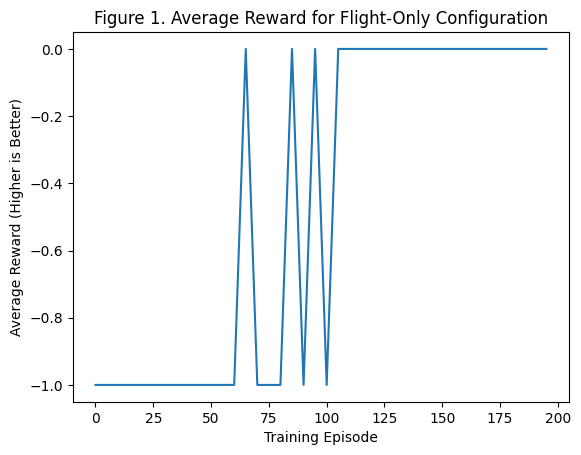

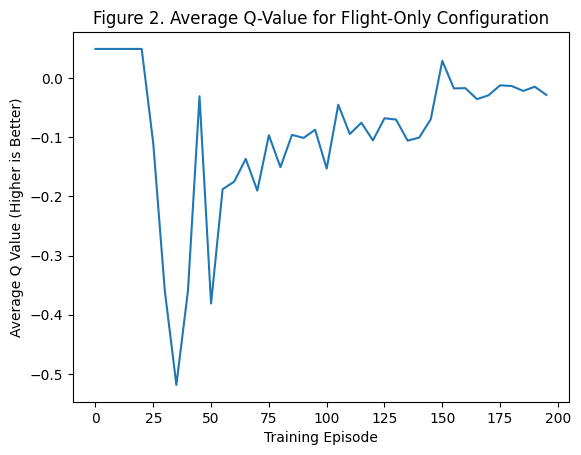

In [2]:
# Plot the flight-only graphs
plot(flight_data.episode, flight_data.avg_reward)
title("Figure 1. Average Reward for Flight-Only Configuration")
ylabel("Average Reward (Higher is Better)")
xlabel("Training Episode")

figure()
plot(flight_data.episode, flight_data.q_vals)
title("Figure 2. Average Q-Value for Flight-Only Configuration")
ylabel("Average Q Value (Higher is Better)")
xlabel("Training Episode");

The network quickly learned to fly, first making it all the way through an episode around its 60th attempt (as seen in Figure 1). It continued to explore alternate possibilities (as is intended with an epsilon-greedy strategy) for another ~40 episodes, before having fully learned to the point that it always completed the episode (presumably learning to recover from errors introduced by epsilon-greedy).

This noise is an inherent part of epsilon-greedy training, and is expected. In fact, this configuration is substantially _less_ noisy because it has a binary reward state (the only non-zero the agent can receive is for the final frame of the game, meaning that the total reward is always either `0` or `-1` in this configuration). Ultimately, the simplicity of the task—and the resulting low number of episodes—result in a not particularly interesting graph. The with-pipes configuration provides a more interesting specimen.

The average Q-value (seen in Figure 2) can be used as a more continuous measure of training progress, especially considering that—as an average—it isn't limited to the same binary as the reward state. These Q-values represent the amount of reward (including the time discount) that the network expects to receive from a predefined set of states. While it isn't free from noise either, it shows a steady increase in the network's ability to play the game over time, before flattening out as the network becomes skilled. The sharp drop at the beginning is the product of the default Q-values (which are set without regard to the environment's rewards) being adjusted to meaningfully correspond to the environment.

The best-performing iteration of the flight-only network is able to fly the flappy bird indefinitely. It immediately raises the bird to the very top of the frame (1px away from the ceiling), presumably so as to give it the most time to recover in the event that episilon-greedy forces the agent to fail to cause the bird to jump when it ought to. Interestingly, this doesn't seem to account for the fact that epsilon-greedy could also force the agent to cause the bird to jump when it shouldn't, and therefore crash into the ceiling. More experimentation would be required to fully understand this behavior.

Once the bird is in position, the agent continuously keeps the bird as close to the top as it can (ie. allowing it to fall just far enough that a tap won't result in it crashing into the ceiling). This oscillation behavior makes sense, as the network is acting deterministically for all possible states within that loop (and therefore has no mechanism to break out of it).

Conceivably, this means the same behavior as the DQN agent could be achieved with the following pseudocode (more complete investigation would be needed to determine if this would actually be equivalent in all cases):

```
Forever:
    # Tap the screen unless doing so would crash into the ceiling
    If CurrentBirdHeight > THRESHOLD (≈ HeightOfCeiling - HeightOfBird):
        Do Nothing
    Else:
        Tap the Screen
    End
End
```

## With Pipes
I then trained the network with full, randomly-generated pipes enabled. Each episode was limited to 1000 frames for efficiency. Training for 7,500 episodes took 3h20m on my test machine.

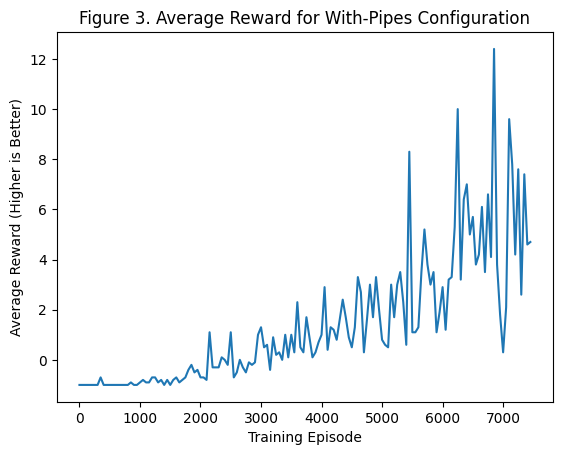

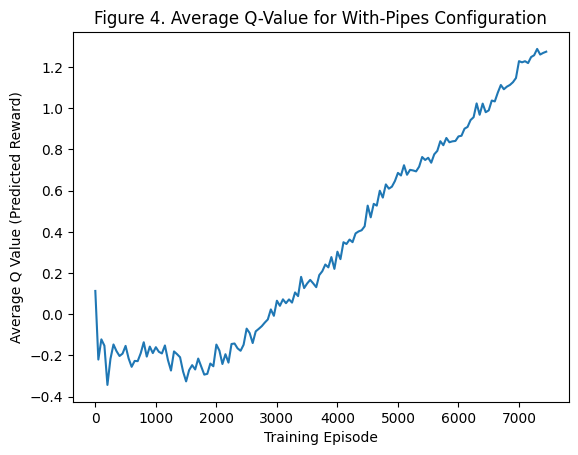

In [3]:
# Plot the with-pipes graphs
plot(pipes_data.episode, pipes_data.avg_reward)
title("Figure 3. Average Reward for With-Pipes Configuration")
ylabel("Average Reward (Higher is Better)")
xlabel("Training Episode")

figure()
plot(pipes_data.episode, pipes_data.q_vals)
title("Figure 4. Average Q-Value for With-Pipes Configuration")
ylabel("Average Q Value (Predicted Reward)")
xlabel("Training Episode");

The additional complexity and training duration of this configuration produces far more interesting data. Figure 3 demonstrates that, while the network did learn significantly, its performance remains extremely noisy and unstable. This is to be expected of an epsilon-greedy training strategy, and is needed for the network to explore new paths it otherwise wouldn't. A much smoother measure of learning can be seen in Figure 4's average Q-values, which show a relatively smooth linear trend upwards over time. (The sharp drop at the beginning is again the adjustment of the default Q values to the reality of the environment, and the Q-values again represent the network's expected reward for a predefined set of states.) In this configuration, the agent receives one reward point for each pipe that it clears, meaning that the reward is theoretically unbounded (up to the episodic limit of 1000 frames per episode). 


The best-performing iteration of the with-pipes network is able to play full Flappy Bird indefinitely, successfully avoiding obstacles—including randomized pipes. By virtue of the drastically higher complexity of the with-pipes configuration, no other patterns in the agents behavior are easily visible. These results demonstrate strong learning, and consequently the viability of a DQN for playing Flappy Bird.

# Conclusion

For this homework, I built a Flappy Bird simulation environment and implemented the epsilon-greedy strategy for a Deep Q Network (DQN). I then trained the network on the Flappy Bird game, both with and without pipes, exclusively using the game's visual pixel output as the network's input. The network successfully learned to play the game, to the point that it could continue to play indefinitely (including with randomly-generated pipes).

During training, the epsilon-greedy strategy results in highly noisy performance when measured by average reward, although measuring average Q-values can produce a more stable measure of learning. This is entirely congruent with Mnih et al.'s results from training a DQN to play classic Atari games exclusively from pixel input, who also found DQNs to be highly effective but with noisy rewards in training.